In [2]:
import numpy as np
from matplotlib import pyplot as plt
from tqdm import trange

$\frac{\partial U}{\partial t} + U\frac{\partial U}{\partial x} = 0$

In [3]:
def flux(U):
    return 0.5 * U ** 2

In [4]:
# space-derivative approximation functions
def central_2(U, h):
    return -U[1:-1] * (U[2:] - U[:-2]) / 2. / h, 1, -1
def central_4(U, h):
    return -U[2:-2] * (U[:-4] - U[4:] + 8. * (U[3:-1] - U[1:-3])) / 12. / h, 2, -2
def central_6(U, h):
    return -U[3:-3] * (U[6:] - U[:-6] + 9. * (U[1:-5] - U[5:-1]) + 45. * (U[4:-2] - U[2:-4])) / 60. / h, 3, -3
def weno_5(U, h):
    N = U.size
    C = np.array([[1./3., 5./6., -1./6.],
                  [-1./6., 5./6., 1./3.],
                  [1./3., -7./6., 11./6.]])
    C_wave = C[::-1, ::-1]
    Ur = np.zeros((3, N))
    Ul = np.zeros((3, N))
    Beta = np.zeros((3, N))
    Beta[0, :-2] = 13./12. * (U[:-2] - 2. * U[1:-1] + U[2:]) ** 2 + 1./4. * (3. * U[:-2] - 4. * U[1:-1] + U[2:]) ** 2
    Beta[1, 1:-1] = 13./12. * (U[:-2] - 2. * U[1:-1] + U[2:]) ** 2 + 1./4. * (U[:-2] - U[2:]) ** 2
    Beta[2, 2:] = 13./12. * (U[:-2] - 2. * U[1:-1] + U[2:]) ** 2 + 1./4. * (U[:-2] - 4. * U[1:-1] + 3. * U[2:]) ** 2
    Beta_wave = Beta[::-1, ::-1]
    d = np.array([0.3, 0.6, 0.1])
    d_wave = d[::-1]
    eps = 1e-40
    alpha = d / (eps + Beta.T) ** 2
    alpha_wave = d_wave / (eps + Beta_wave.T) ** 2
    W = alpha.T / np.sum(alpha, axis = 1)
    W_wave = alpha_wave.T / np.sum(alpha_wave, axis = 1)
    for r in range(3):
        right = N - 2 + r
        Ur[r, r:right] = C[r, 0] * U[:-2] + C[r, 1] * U[1:-1] + C[r, 2] * U[2:]
        Ul[r, r:right] = C_wave[r, 0] * U[:-2] + C_wave[r, 1] * U[1:-1] + C_wave[r, 2] * U[2:]
    U_R = np.sum(W * Ur, axis = 0)
    U_L = np.sum(W_wave * Ul, axis = 0)
    U_big = np.zeros(len(U) + 1)
    U_big[0] = U_L[0]
    U_big[-1] = U_R[-1]
    U_big[1:-1] = 0.5 * (U_R[:-1] + U_L[1:] + (U_R[:-1] - U_L[1:]) * np.sign(U_R[:-1] + U_L[1:]))
    Flux = -0.5 * (U_big[1:] ** 2 - U_big[:-1] ** 2) / h
    return Flux, 0, None

In [5]:
# time-derivative approximation functions
def runge_kutta_2(U, h, r, Deriv):
    dt = r * h
    k1 = np.zeros_like(U)
    k2 = np.zeros_like(U)
    temp1, idx_l, idx_r = Deriv(U, h)
    k1[idx_l:idx_r] = temp1
    temp2, idx_l, idx_r = Deriv(U + dt * k1, h)
    k2[idx_l:idx_r] = temp2
    return U + 0.5 * dt * (k1 + k2), dt, 0, None
def runge_kutta_3(U, h, r, Deriv):
    dt = r * h
    k1 = np.zeros_like(U)
    k2 = np.zeros_like(U)
    k3 = np.zeros_like(U)
    temp1, idx_l, idx_r = Deriv(U, h)
    k1[idx_l:idx_r] = temp1
    temp2, idx_l, idx_r = Deriv(U + dt * k1 / 3., h)
    k2[idx_l:idx_r] = temp2
    temp3, idx_l, idx_r = Deriv(U + 2. * dt * k2 / 3., h)
    k3[idx_l:idx_r] = temp3
    return U + 0.25 * dt * (k1 + 3  * k3), dt, 0, None
def runge_kutta_4(U, h, r, Deriv):
    dt = r * h
    k1 = np.zeros_like(U)
    k2 = np.zeros_like(U)
    k3 = np.zeros_like(U)
    k4 = np.zeros_like(U)
    temp1, idx_l, idx_r = Deriv(U, h)
    k1[idx_l:idx_r] = temp1
    temp2, idx_l, idx_r = Deriv(U + dt * k1 / 2., h)
    k2[idx_l:idx_r] = temp2
    temp3, idx_l, idx_r = Deriv(U + dt * k2 / 2., h)
    k3[idx_l:idx_r] = temp3
    temp4, idx_l, idx_r = Deriv(U + dt * k3, h)
    k4[idx_l:idx_r] = temp4
    return U + dt * (k1 / 6. + k2 / 3. + k3 / 3. + k4 / 6.), dt, 0, None
def runge_kutta_5(U, h, r, Deriv):
    dt = r * h
    k1 = np.zeros_like(U)
    k2 = np.zeros_like(U)
    k3 = np.zeros_like(U)
    k4 = np.zeros_like(U)
    k5 = np.zeros_like(U)
    k6 = np.zeros_like(U)
    temp1, idx_l, idx_r = Deriv(U, h)
    k1[idx_l:idx_r] = temp1
    temp2, idx_l, idx_r = Deriv(U + dt * k1 / 4., h)
    k2[idx_l:idx_r] = temp2
    temp3, idx_l, idx_r = Deriv(U + dt * (k1 / 8. + k2 / 8.), h)
    k3[idx_l:idx_r] = temp3
    temp4, idx_l, idx_r = Deriv(U + dt * k3 / 2., h)
    k4[idx_l:idx_r] = temp4
    temp5, idx_l, idx_r = Deriv(U + dt * (3. * k1 / 16. - 3. * k2 / 8. + 3. * k3 / 8. + 9. * k4 / 16.), h)
    k5[idx_l:idx_r] = temp5
    temp6, idx_l, idx_r = Deriv(U + dt * (- 3. * k1 / 7. + 8. * k2 / 7. + 6. * k3 / 7. - 12. * k4 / 7. + 8. * k5 / 7.), h)
    k6[idx_l:idx_r] = temp6
    return U + dt * (7. * k1 / 90. + 16. * k3 / 45. + 2. * k4 / 15. + 16. * k5 / 45. + 7. * k6 / 90.), dt, 0, None
def runge_kutta_7(U, h, r, Deriv):
    dt = r * h
    k1 = np.zeros_like(U)
    k2 = np.zeros_like(U)
    k3 = np.zeros_like(U)
    k4 = np.zeros_like(U)
    k5 = np.zeros_like(U)
    k6 = np.zeros_like(U)
    k7 = np.zeros_like(U)
    k8 = np.zeros_like(U)
    k9 = np.zeros_like(U)
    temp1, idx_l, idx_r = Deriv(U, h)
    k1[idx_l:idx_r] = temp1
    temp2, idx_l, idx_r = Deriv(U + dt * k1  / 6.0, h)
    k2[idx_l:idx_r] = temp2
    temp3, idx_l, idx_r = Deriv(U + dt * k2  / 3.0, h)
    k3[idx_l:idx_r] = temp3
    temp4, idx_l, idx_r = Deriv(U + dt * (k1  / 8.0 + k3 * 3.0  / 8.0), h)
    k4[idx_l:idx_r] = temp4
    temp5, idx_l, idx_r = Deriv(U + dt * (k1 * 148.0  / 1331.0 + k3 * 150.0  / 1331.0 - k4 * 56.0  / 1331.0), h)
    k5[idx_l:idx_r] = temp5
    temp6, idx_l, idx_r = Deriv(U + dt * (-k1 * 404.0  / 243.0 - k3 * 170.0  / 27.0 + k4 * 4024.0  / 1701.0 + k5 * 10648.0  / 1701.0), h)
    k6[idx_l:idx_r] = temp6
    temp7, idx_l, idx_r = Deriv(U + dt * (k1 * 2466.0  / 2401.0 + k3 * 1242.0  / 343.0 - k4 * 19176.0  / 16807.0 - k5 * 51909.0  / 16807.0 + k6 * 1053.0  / 2401.0), h)
    k7[idx_l:idx_r] = temp7
    temp8, idx_l, idx_r = Deriv(U + dt * (k1 * 5.0  / 154.0 + k4 * 96.0  / 539.0 - k5 * 1815.0  / 20384.0 - k6 * 405.0  / 2464.0 + k7 * 49.0  / 1144.0), h)
    k8[idx_l:idx_r] = temp8
    temp9, idx_l, idx_r = Deriv(U + dt * (-k1 * 113.0  / 32.0 - k3 * 195.0  / 22.0 + k4 * 32.0  / 7.0 + k5 * 29403.0  / 3584.0 - k6 * 729.0  / 512.0 + k7 * 1029.0  / 1408.0 + k8 * 21.0  / 16.0), h)
    k9[idx_l:idx_r] = temp9
    return U + dt * (k4 * 32.0  / 105.0 + k5 * 1771561.0  / 6289920.0 + k6 * 243.0  / 2560.0 + k7 * 16807.0  / 74880.0 + k8 * 77.0  / 1440.0 + k9 * 11.0  / 270.0), dt, 0, None

In [6]:
class SolverHopf:
    def __init__(self, h, r, T = 20.):
        self.h = h
        self.r = r
        self.x = np.linspace(0, 3000, int(3000 // h) + 1)
        self.U = np.zeros_like(self.x)
        self.U_ex = np.zeros_like(self.x)
        self.T = T
    def initial(self):
        x0 = int(1480 / self.h)
        x1 = int(1520 / self.h)
        self.U[:x0] = 1.
        self.U[x1:] = -1.
        self.U[x0:x1] = -self.x[x0:x1] / 20. + 75. #np.linspace(1., -1., x1 - x0)
        if self.T < 20.:
            x0 = int(1480 / self.h) + int(self.T / self.h)
            x1 = int(1520 / self.h) - int(self.T / self.h)
            self.U_ex[:x0] = 1.
            self.U_ex[x1:] = -1.
            k = 2. / (self.x[x0] - self.x[x1])
            b = 1. - k * self.x[x0]
            self.U_ex[x0:x1] = k * self.x[x0:x1] + b #np.linspace(1., -1., x1 - x0)
        else:
            mid = int(1500. / self.h)
            self.U_ex[:mid] = 1.
            self.U_ex[mid] = 0.
            self.U_ex[mid + 1:] = -1.
    def solve(self, F, Deriv):
        temp, dt, idx_l, idx_r = F(self.U, self.h, self.r, Deriv)
        self.U[idx_l : idx_r] = temp
        Nt = int(self.T / dt)
        for i in trange(Nt):
            if i == 0: continue
            temp, dt, idx_l, idx_r = F(self.U, self.h, self.r, Deriv)
            self.U[idx_l : idx_r] = temp
    def error(self):
        x0 = int(1480 / self.h)
        x1 = int(1520 / self.h)
        intLdh = int(50 / self.h)
        return np.sqrt(np.sum((self.U[x0 - intLdh: x1 + intLdh] - self.U_ex[x0 - intLdh: x1 + intLdh]) ** 2 * self.h))
    def draw(self, axs, ylabel):
        x0 = int(1480 / self.h)
        x1 = int(1520 / self.h)
        x0 += int(self.T / self.h)
        x1 -= int(self.T / self.h)
        lim = 1.5 if self.T <= 20. else 4
        axs.set_ylim([-lim, lim])
        intLdh = int(100 / self.h)
        axs.plot(self.x[x0 - intLdh: x1 + intLdh], self.U[x0 - intLdh: x1 + intLdh], label = ylabel)
        axs.set_xlabel('x')
        axs.set_ylabel('U')
        axs.legend()
    def draw_exact(self, axs):
        x0 = int(1480 / self.h)
        x1 = int(1520 / self.h)
        x0 += int(self.T / self.h)
        x1 -= int(self.T / self.h)
        lim = lim = 1.5 if self.T <= 20. else 4
        axs.set_ylim([-lim, lim])
        intLdh = int(100 / self.h)
        axs.plot(self.x[x0 - intLdh: x1 + intLdh], self.U_ex[x0 - intLdh: x1 + intLdh], '--', label = 'exact')
        axs.set_xlabel('x')
        axs.set_ylabel('U')
        axs.legend()

In [7]:
def solve_for_different_F(H, r, T, deriv_t, deriv_x_array):
    fig = plt.figure(figsize = (20, 25))
    axs = fig.add_subplot(211)
    axs.grid()
    solver = SolverHopf(H, r, T)
    for deriv in deriv_x_array:
        solver.initial()
        solver.solve(deriv_t, deriv)
        ylabel = str(deriv_t).split(' ')[1] + '+' + str(deriv).split(' ')[1]
        solver.draw(axs, ylabel)
        print(solver.error())
    solver.draw_exact(axs)

100%|██████████| 80/80 [00:00<00:00, 3488.20it/s]


9.609909447269583


100%|██████████| 80/80 [00:00<00:00, 3087.23it/s]


5.729599730744862


100%|██████████| 80/80 [00:00<00:00, 2866.65it/s]


4.7246494625536855


100%|██████████| 80/80 [00:00<00:00, 506.22it/s]


3.7964617296440183e-13


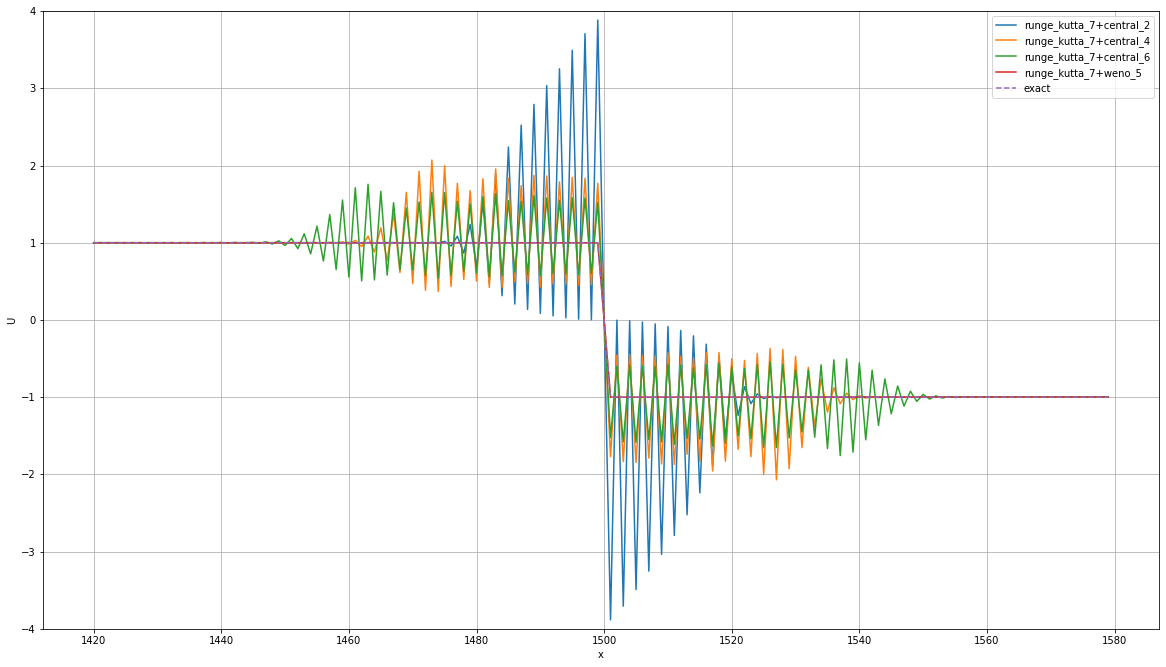

In [10]:
r = .5
T = 40.
H = 1.

solve_for_different_F(H, r, T, runge_kutta_7, [central_2, central_4, central_6, weno_5])

100%|██████████| 80/80 [00:00<00:00, 494.74it/s]


3.7964617296440183e-13


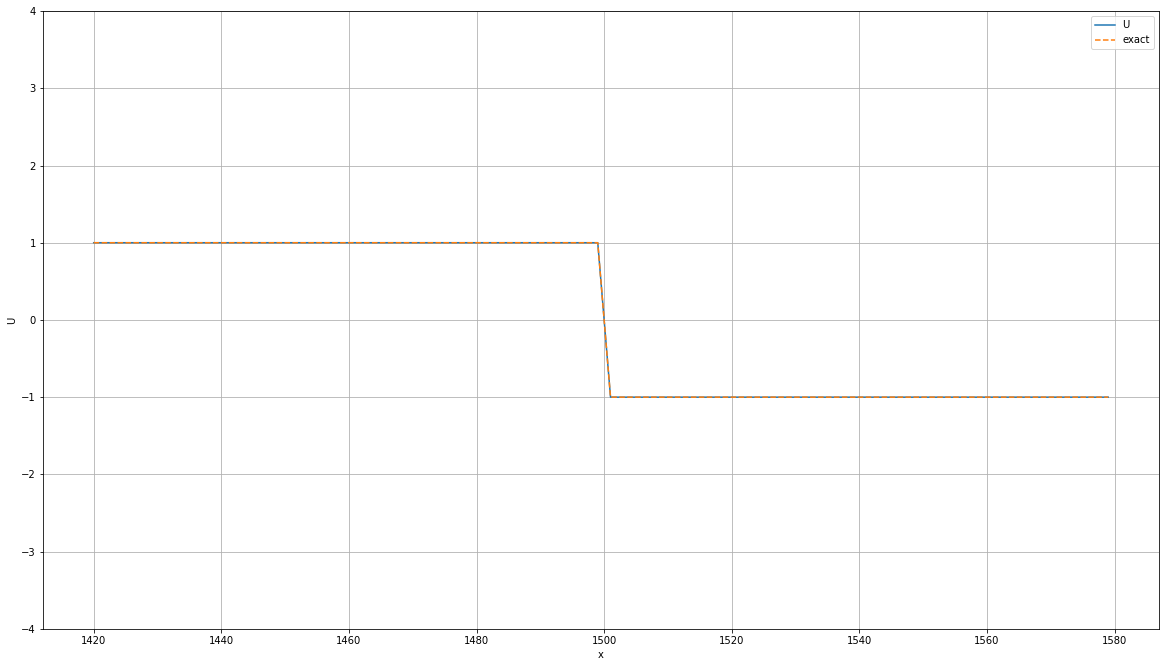

In [ ]:
T = 40
solver = SolverHopf(H, r, T)
solver.initial()
solver.solve(runge_kutta_7, weno_5)

fig = plt.figure(figsize = (20, 25))
axs = fig.add_subplot(211)
axs.grid()
solver.draw(axs, 'U')
solver.draw_exact(axs)
print(solver.error())